**Цель работы**: проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

**План работы**: 
1. [Изучить общую информацию о данных](#shag1)
2. [Выполнить предобработку данных](#shag2)
3. [Провести исследовательский анализ данных.](#shag3)
4. [Объединить данные.](#shag4)
5. [Провести подсчёт общей выручки.](#shag5)
6. [Проверить гипотизы, сформировавшиеся в процессе анализа данных.](#shag6)
7. [Ответить на запросы отдела маркетинга.](#shag7)
8. [Общий вывод](#shag8)

# 1. Загрузка данных: обзор и предобработка<a id="shag1_"></a>  

In [1]:
import pandas as pd
import numpy as np

import math
from math import sqrt
from scipy import stats as st
from scipy.stats import binom, norm

import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

# Шаг 1. Загрузка данных<a id="shag1"></a> 

In [2]:
raw_users = pd.read_csv('/datasets/users_go.csv')
raw_rides = pd.read_csv('/datasets/rides_go.csv')
raw_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

Изучим общую информацию о данных

In [3]:
raw_users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


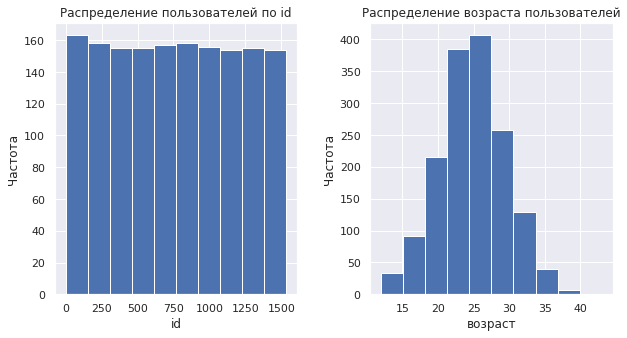

In [4]:
raw_users_hist_titles = ['Распределение пользователей по id', 'Распределение возраста пользователей']
raw_users_xlabel = ['id', 'возраст']
axes = raw_users.hist(figsize=(10, 5)).ravel()
for i in range(len(axes)): 
    axes[i].set_title(raw_users_hist_titles[i])
    axes[i].set_ylabel('Частота')
    axes[i].set_xlabel(raw_users_xlabel[i])

plt.show();

In [6]:
raw_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [7]:
raw_rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [8]:
raw_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


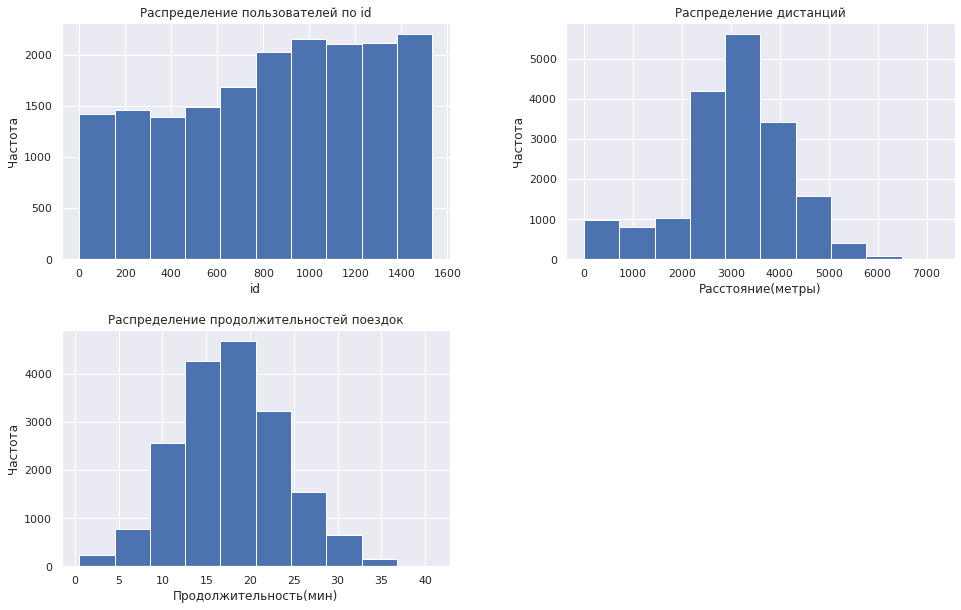

In [9]:
raw_rides_hist_titles = ['Распределение пользователей по id',
                         'Распределение дистанций',
                         'Распределение продолжительностей поездок']
raw_rides_xlabel = ['id', 'Расстояние(метры)', 'Продолжительность(мин)']
axes = raw_rides.hist(figsize=(16, 10)).ravel()

for i in range(len(axes)): 
    try:
        axes[i].set_title(raw_rides_hist_titles[i])
        axes[i].set_ylabel('Частота')
        axes[i].set_xlabel(raw_rides_xlabel[i])
    except:
        pass

plt.show();


In [10]:
raw_subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [11]:
raw_subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [12]:
raw_users.duplicated().sum() 

31

In [13]:
raw_rides.duplicated().sum()

0

In [14]:
raw_subscriptions.duplicated().sum()

0

**Обзор данных**:
- в данных отсутствуют пропущенные значения,
- тип данных параметра *subscription_type* в таблицах **raw_subscriptions** и **raw_users** следует изменить на int для дальнейшего анализа данных,
- тип данных параметра *date* в таблице **raw_rides** следует изменить на datetime,
- в столбцe *distance* таблицы **raw_rides** замечены аномальные значения,
- явные дубликаты замечены в таблице **raw_users**.

# Шаг 2. Предобработка данных<a id="shag2"></a> 

Изменим тип данных параметра *date* в таблице **raw_rides** на datetime

In [15]:
raw_rides['date'] = pd.to_datetime(raw_rides['date'], format='%Y-%m-%d')

Создадим функцию, которая будет менять значение ultra на 1, а free на 0

In [16]:
def sub_to_int(row):
    sub = row['subscription_type']
    return 1 if sub == 'ultra' else 0

In [17]:
raw_subscriptions['subscription_type'] = raw_subscriptions.apply(sub_to_int, axis=1)
raw_users['subscription_type'] = raw_users.apply(sub_to_int, axis=1)

Cоздадим новый столбец с номером месяца на основе столбца *date*

In [18]:
raw_rides['month'] = raw_rides['date'].dt.month

Удалим явные дубликаты из таблицы **raw_users**

In [19]:
raw_users.drop_duplicates(inplace=True)

Проверим таблицу **raw_users** на наличие неявных дубликатов

In [20]:
raw_users['name'].unique()

array(['Кира', 'Станислав', 'Алексей', 'Константин', 'Адель', 'Регина',
       'Игорь', 'Юрий', 'Ян', 'Валерий', 'Агата', 'Марк', 'Ева',
       'Антонина', 'Валерия', 'Амалия', 'Даниил', 'Аделина', 'Святогор',
       'Борис', 'Вероника', 'Ростислав', 'Назар', 'Эдуард', 'Василий',
       'Денис', 'Тамара', 'Николай', 'Эвелина', 'Федор', 'Руслан', 'Иван',
       'Любовь', 'Ярослава', 'Майя', 'Ильдар', 'Данила', 'Нина',
       'Стефания', 'Ясмина', 'Дмитрий', 'Александр', 'Одиссей', 'Арсений',
       'Алла', 'Таисия', 'Максим', 'Юлиана', 'Павел', 'Карина', 'Алиса',
       'Лидия', 'Рамиль', 'Родион', 'Ника', 'Оксана', 'Анастасия',
       'Маргарита', 'Вера', 'Тимур', 'Никита', 'Лев', 'Влад', 'Артур',
       'Анна', 'Ольга', 'Вячеслав', 'Ксения', 'Виталина', 'Владислав',
       'Тамерлан', 'Амина', 'Вадим', 'Олеся', 'Зарина', 'Егор', 'Гордей',
       'Лилия', 'Святослав', 'Роберт', 'Амир', 'Влада', 'Богдан',
       'Полина', 'Марат', 'Елисей', 'Макар', 'Алина', 'Глеб', 'Андрей',
       'Ал

In [21]:
raw_users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

**В результате предобработки данных были:**

- изменены типы данных столбцов date и subscription_type в таблице raw_users, изменён тип данных столбца date на datetime, subscription_type в raw_subscriptions теперь имеет только int-значения,
- удалены неявные дубликаты,
- проверены данные на неявные дубликаты

# Шаг 3. Исследовательский анализ данных<a id="shag3"></a> 

Посмотрим на общую информацию о пользователях и поездках

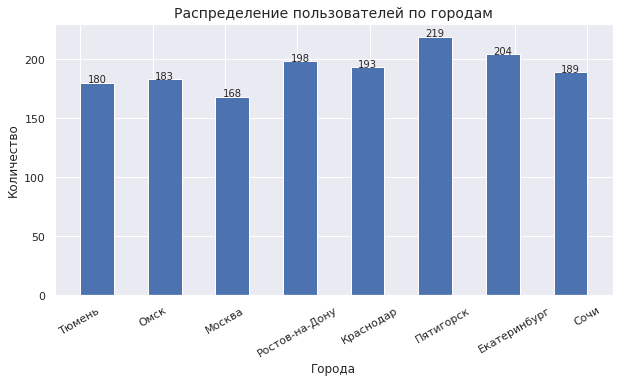

In [22]:
plt.figure(figsize=(10, 5))
plt.ylabel("Количество")
plt.xlabel("Города")
plt.xticks(rotation=30)
ax = raw_users['city'].hist(bins=15)
axes = plt.gca()

for patch in axes.patches:
    value = int(patch.get_height())
    if value > 0: 
        axes.text(
            patch.get_x() + patch.get_width() / 2.,
            value,
            f"{value}",
            fontsize=10,
            ha='center',
        )
plt.title("Распределение пользователей по городам", fontsize=14)

plt.show();

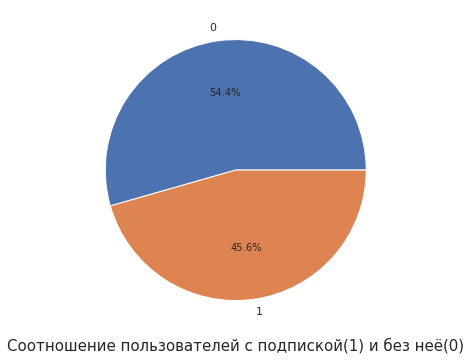

In [24]:
plt.figure(figsize=(6, 6))
plt.xlabel("Соотношение пользователей с подпиской(1) и без неё(0)", fontsize=15)

ax = raw_users['subscription_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
ax.set(ylabel=None)
plt.show();

In [25]:
raw_users[raw_users['subscription_type'] == 0].shape[0] / raw_users[raw_users['subscription_type'] == 1].shape[0]

1.1945636623748213

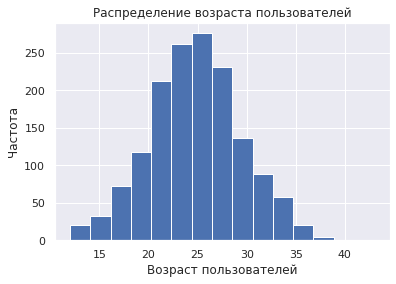

In [26]:
plt.ylabel("Частота")
plt.xlabel("Возраст пользователей")

raw_users['age'].hist(bins=15)
plt.title('Распределение возраста пользователей')
plt.show();

In [27]:
most_age = raw_users.groupby('age').sum()
most_age['subscription_type'][7:-8].count() / most_age['subscription_type'].count()

0.4827586206896552

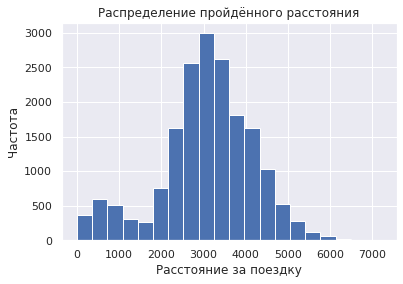

In [28]:
plt.ylabel("Частота")
plt.xlabel("Расстояние за поездку")

raw_rides['distance'].hist(bins=20)
plt.title('Распределение пройдённого расстояния')
plt.show();

In [29]:
raw_rides['distance'].mean()

3070.6599756818814

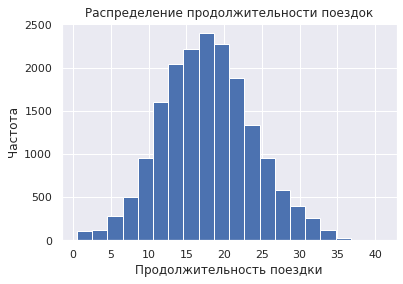

In [30]:
plt.ylabel("Частота")
plt.xlabel("Продолжительность поездки")

raw_rides['duration'].hist(bins=20)
plt.title('Распределение продолжительности поездок')
plt.show();

In [31]:
raw_rides['duration'].mean()

17.80501119798444

**В ходе исследовательского анализа данныx было обнаружено, что**

- пользователи практически равномерно распределены между городами,
- пользователей без подписки на 20%(19.4%) больше, чем пользователей с подпиской,
- половина(48%) пользователей находятся в возрасте 19-31 года,
- среднее расстояние за поездку составляет 3070 метров,
- средняя продолжительность поездки - 17 минут,
- все параметры кроме *distance* соответствуют нормальному распределению

# Шаг 4. Объединение данных<a id="shag4"></a> 

In [32]:
raw_users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,1
1,2,Станислав,31,Омск,1
2,3,Алексей,20,Москва,1
3,4,Константин,26,Ростов-на-Дону,1
4,5,Адель,28,Омск,1


In [33]:
raw_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 71.9+ KB


In [34]:
raw_rides.shape[0]

18068

In [35]:
raw_subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,0,8,50,0
1,1,6,0,199


Объединим данные о пользователях, поездках и подписках в один датафрейм. 

In [36]:
data = raw_users.merge(raw_rides, on='user_id').merge(raw_subscriptions, on='subscription_type')

In [37]:
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,1,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,1,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,1,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,1,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,1,4028.687306,26.265803,2021-08-28,8,6,0,199


Создадим два датафрейма с пользователями, у которых есть подписка и у которых её нет.

In [38]:
unsubscribed_data = data[data['subscription_type'] == 0]
subscribed_data = data[data['subscription_type'] == 1]

Сравним показатели *duration* и *distance* у обоих датафреймов

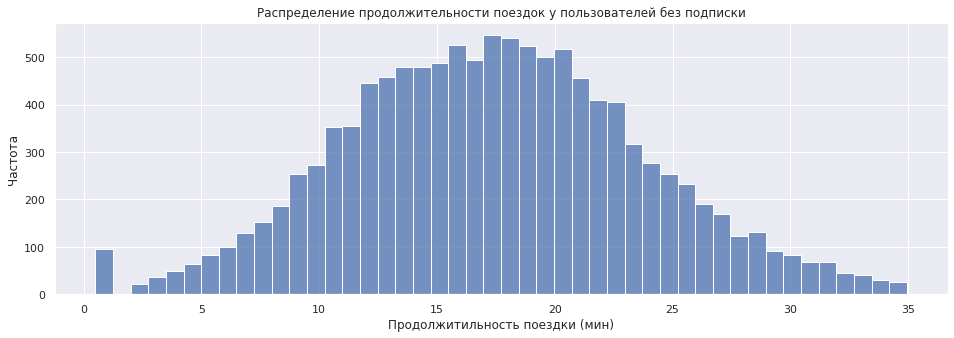

In [39]:
fig, ax = plt.subplots(figsize=(16, 5))
ax=sns.histplot(data=unsubscribed_data, x='duration')
plt.xlabel('Продолжитильность поездки (мин)')
plt.ylabel('Частота')
plt.title('Распределение продолжительности поездок у пользователей без подписки')
plt.show();

На графике заметен выброс данных около нуля минут. Я предполагаю, что такие поездки совершали новые пользователи, которые хотели только опробовать новый вид транспорта, а значит, они быстро заканчивали поездку.

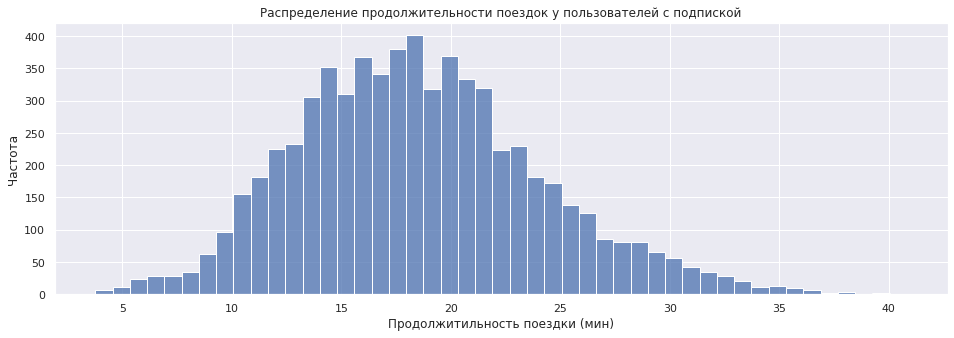

In [40]:
fig, ax = plt.subplots(figsize=(16, 5))
ax=sns.histplot(data=subscribed_data, x='duration')
plt.xlabel('Продолжитильность поездки (мин)')
plt.ylabel('Частота')
plt.title('Распределение продолжительности поездок у пользователей с подпиской')
plt.show();

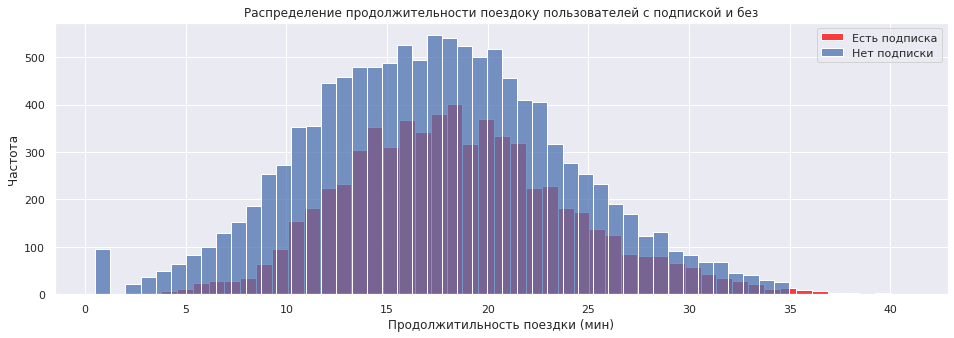

In [41]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.histplot(data=subscribed_data, x='duration', color='red', multiple="stack", ax=ax)
sns.histplot(data=unsubscribed_data, x='duration', multiple="stack", ax=ax)
plt.xlabel('Продолжитильность поездки (мин)')
plt.ylabel('Частота')
plt.legend(["Есть подписка", "Нет подписки"])
plt.title('Распределение продолжительности поездоку пользователей с подпиской и без')
plt.show();

In [42]:
unsubscribed_data['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

In [43]:
subscribed_data['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

Удивительно, но большинство поездок пользователей с подпиской длится столько же, сколько и у пользователей без подписки

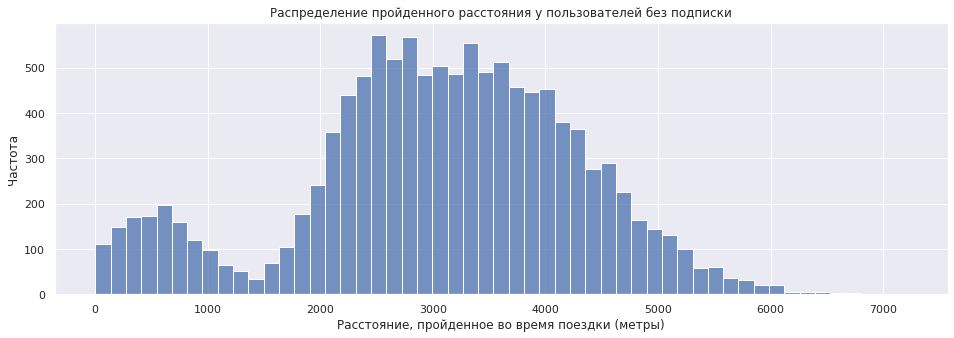

In [44]:
fig, ax = plt.subplots(figsize=(16, 5))
ax=sns.histplot(data=unsubscribed_data, x='distance')
plt.xlabel('Расстояние, пройденное во время поездки (метры)')
plt.ylabel('Частота')
plt.title('Распределение пройденного расстояния у пользователей без подписки')
plt.show();

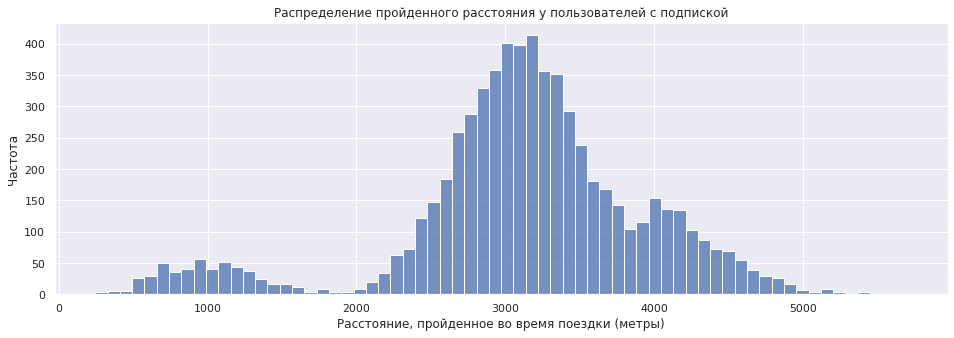

In [45]:
fig, ax = plt.subplots(figsize=(16, 5))
ax=sns.histplot(data=subscribed_data, x='distance')
plt.xlabel('Расстояние, пройденное во время поездки (метры)')
plt.ylabel('Частота')
plt.title('Распределение пройденного расстояния у пользователей с подпиской')
plt.show();

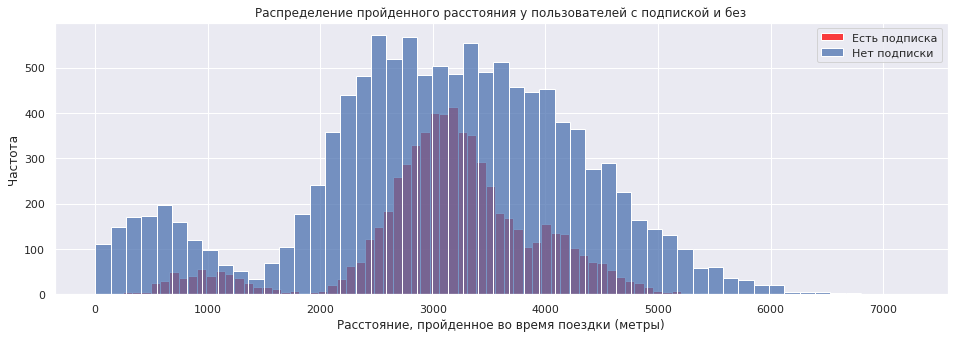

In [46]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.histplot(data=subscribed_data, x='distance', color='red', multiple="stack", ax=ax)
sns.histplot(data=unsubscribed_data, x='distance', multiple="stack", ax=ax)
plt.xlabel('Расстояние, пройденное во время поездки (метры)')
plt.ylabel('Частота')
plt.legend(["Есть подписка", "Нет подписки"])
plt.title('Распределение пройденного расстояния у пользователей с подпиской и без')
plt.show();

In [47]:
unsubscribed_data['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In [48]:
subscribed_data['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

Данные по пройденной дистанции говорят нам о том, что среднее расстояние, пройденное пользователими с подпиской и без, хоть и слабо, но отличается. Так, 75% пользователей с подпиской проезжают более 2785 метров, в то время, как тот же процент пользователей без подписки проезжает более 2366 метров. Однако нужно иметь в виду, что количество данных пользователей с подпиской и без отличается в 2 раза.

**В ходе объединения данных:**

- были создана таблица **data**, основанная на данных из таблиц **raw_users, raw_rides, raw_subscriptions**,
- были созданы таблицы **subscribed_data** и **unsubscribed_data** о пользователях с подпиской и без соответственно,
- был произведён анализ параметров *distance* и *duration* в таблицах **subscribed_data** и **unsubscribed_data**

# Шаг 5. Подсчёт выручки<a id="shag5"></a> 

Создадим датафрейм, в котором будут данные о суммарном расстоянии, наличии подписки, количестве поездок и суммарном времени для каждого пользователя за каждый месяц.

In [49]:
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,1,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,1,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,1,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,1,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,1,4028.687306,26.265803,2021-08-28,8,6,0,199


In [50]:
user_data_by_month = (
    data
    .groupby(['user_id', 'month'])
    .agg({'distance': 'sum', 'duration': 'sum', 'month': 'count', 'subscription_type': 'sum'})
    .rename(columns={'month': 'rides_count', 'subscription_type': 'has_subscription'})
)
user_data_by_month.head()

distance   duration  rides_count  has_subscription
user_id month                                                       
1       1      7027.511294  41.416640            2                 2
        4       754.159807   6.232113            1                 1
        8      6723.470560  44.776802            2                 2
        10     5809.911100  31.578017            2                 2
        11     7003.499363  53.397424            3                 3

Добавим столбец с помесячной выручкой, которую принёс каждый пользователь

In [51]:
def set_gain(row):
    if row['has_subscription'] == 0:
        return 50 * row['rides_count'] + 8 * math.ceil(row['duration']) + 0
    else:
        return row['rides_count'] + 6 * math.ceil(row['duration']) + 199

In [52]:
user_data_by_month['gain'] = user_data_by_month.apply(set_gain, axis=1)

In [53]:
user_data_by_month['has_subscription'] = user_data_by_month['has_subscription'].apply(lambda x: int(x != 0))

In [54]:
user_data_by_month['duration'] = np.ceil(user_data_by_month['duration'])

In [55]:
gain_data = user_data_by_month.copy()
gain_data.head()

distance  duration  rides_count  has_subscription   gain
user_id month                                                             
1       1      7027.511294      42.0            2                 1  453.0
        4       754.159807       7.0            1                 1  242.0
        8      6723.470560      45.0            2                 1  471.0
        10     5809.911100      32.0            2                 1  393.0
        11     7003.499363      54.0            3                 1  526.0

**В ходе подсчёта выручки**:

- была создана таблица **gain_data**, которая показывает месячную выручку, дистанцию, продожительность поездок, наличие подписки, а также количество поездок.

# Шаг 6. Проверка гипотез<a id="shag6"></a> 

## Тратят ли пользователи с подпиской больше времени на поездки?

Сравним данные о времени, которое тратят на поездку пользователи с подпиской и без неё.

Для более надёжной проверки гипотезы будем использовать t-тест, в котором:

*Нулевая гипотеза*: пользователи с подпиской тратят столько же времени на поездку, сколько и пользователи без подписки

*Альтернативная гипотеза*: пользователи с подпиской тратят больше времени на поездку, чем пользователи без подписки

In [56]:
alpha = 0.01

results = st.ttest_ind(subscribed_data['duration'], unsubscribed_data['duration'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Полученное значение p-value меньше заданного уровня значимости(alpha = 0.01), поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что пользователи с подпиской тратят больше времени на поездку.

## Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает оптимальное расстояние с точки зрения износа самоката.

Применим t-тест к выборке, чтобы узнать, проезжают ли пользователи с подпиской расстояние, меньшее оптимального

*Нулевая гипотеза*: пользователи с подпиской проезжают расстояние, равное оптимальному

*Альтернативная гипотеза*: подписчики в среднем проезжают расстояние, большее оптимального

In [57]:
interested_value = 3130

alpha = 0.05

results = st.ttest_1samp(
    subscribed_data['distance'],
    interested_value,
    alternative='greater'
)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value больше заданного уровня значимости(alpha = 0.05), поэтому нулевую гипотезу не следует отвергать.
А значит, есть основания предполагать, что пользователи с подпиской проезжают расстояние, равное оптимальному для самоката.

## Будет ли помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки?

Создадим таблицы, в которых будут данные о помесячной выручке с пользователей с подпиской и без

In [58]:
subscibed_gain = gain_data[gain_data['has_subscription'] == 0].groupby('month').agg({'gain': 'sum'})
unsubscibed_gain = gain_data[gain_data['has_subscription'] == 1].groupby('month').agg({'gain': 'sum'})

Используем t-тест, чтобы узнать, как различается выручка между пользователями с подпиской и без

*Нулевая гипотеза*: пользователи с подпиской приносят сервису столько же выручки, сколько и пользователи без подписки

*Альтернативная гипотеза*: пользователи с подпиской приносят сервису больше выручки, чем пользователи без подписки

In [59]:
alpha = 0.01

results = st.ttest_ind(subscibed_gain['gain'], unsubscibed_gain['gain'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 4.229134759489024e-13
Отвергаем нулевую гипотезу


Полученное значение p-value меньше заданного уровня значимости(alpha = 0.01), поэтому нулевую гипотезу следует отвергнуть. А значит, пользователи с подпиской действительно приносят сервису больше денег, чем пользователи без подписки

## Количество обращений в техподдержку значимо снизилось после обновления серверов?

Для проверки гипотезы о том, что обновление серверов привело к снижению количества обращений пользователей в техподдержку, следует применить t-тест(ttest_rel) для сравнения среднего значения связанных выборок.

Сформулирем одностороннюю гипотезу:

*Нулевая гипотеза*: количество обращений в техподдержку не изменилось

*Альтернативная гипотеза*: количество обращений в техподдержку снизилось

**В ходе проверки гипотез мы выявили, что:**

- пользователи с подпиской тратят больше времени на поездку,
- пользователи с подпиской проезжают расстояние, равное оптимальному для самоката,
- помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки

# Шаг 7. Распределения<a id="shag7"></a> 

## Нужное количестве промокодов для удачного проведения акции

Используем биномиальное распределение, которое описывает указанную ситуацию

In [60]:
from scipy import stats as st
from scipy.stats import binom

p1 = 0.1
k1 = 100
alpha1 = 0.05 

n1 = k1 // p1 + 1  
while True:
    F_k = binom.cdf(k1, n1, p1)
    if F_k <= alpha1:
        break
    n1 += 1
n1

1172.0

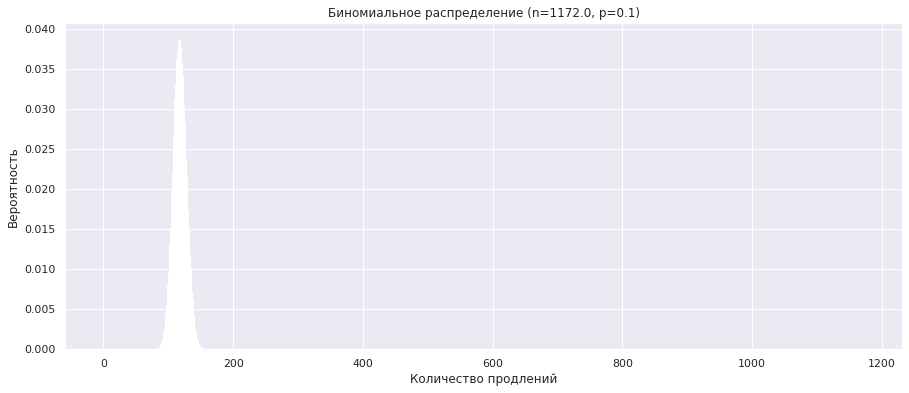

In [61]:
x = range(int(n1)+1)
pmf = binom.pmf(x, n1, p1)
plt.figure(figsize=(15, 6))

plt.bar(x, pmf, color='orange', alpha=1)
plt.xlabel("Количество продлений")
plt.ylabel("Вероятность")
plt.title(f"Биномиальное распределение (n={n1}, p={p1})")
plt.grid(True)
plt.show()

В ходе исследования было обнаружено, что минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план(100 продлений подписок) была примерно 5%, составляет 1172.

## Поиск вероятности открыть push-уведомления 

Данная ситуация так же описывается биномиальным распределением. Но считать каждое отдельное значение достаточно долго, так что воспользуемся нормальной аппроксимацией биномиального распределения и cdf() для быстрой оценки.

In [62]:
n = 10**6
p = 0.4

mu = n * p
sigma = (n * p * (1 - p)) ** 0.5

distr = st.norm(mu, sigma) 

result = distr.cdf(399500)
result

0.15371708296369768

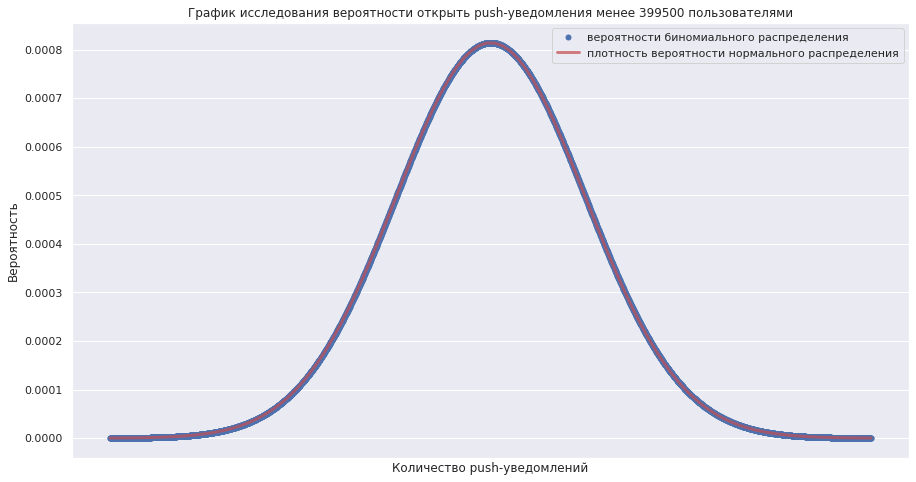

In [63]:
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
 
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
 
x = list(range(max(0, left), right))

plt.figure(figsize=(15, 8))
ax = plt.subplot()

ax.plot(x, binom.pmf(x, n, p), 'bo', ms=5,
	      label='вероятности биномиального распределения')

 
x = linspace(left, right, 100)

ax.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=3, alpha=0.7, label='плотность вероятности нормального распределения')
 

x_ticks = list(range(int(mu - 3 * sigma), int(mu + 3 * sigma), 1))
ax.set_xticks(x_ticks)

ax.legend(loc='best')
#метки плохо отображаются
plt.xlabel('Количество push-уведомлений')
plt.ylabel('Вероятность')
plt.title('График исследования вероятности открыть push-уведомления менее 399500 пользователями')
plt.xticks([])
plt.show()

C помощью аппроксимации биномиального распределения в ходе быстрой оценки было выявлено, что с 15.3% вероятностью уведомление откроют не более 399.5 тыс. пользователей

**В ходе работы с запросами отдела маркетинга:**

- было найдено нужное количестве промокодов для удачного проведения акции(1172),
- была найдена вероятность того, что определённое число пользователей откроет уведомление(15.3%)

# Общий вывод:<a id="shag8"></a> 

**Обзор данных**:
- в данных отсутствуют пропущенные значения,
- тип данных параметра *subscription_type* в таблицах **raw_subscriptions** и **raw_users** следует изменить на int для дальнейшего анализа данных,
- тип данных параметра *date* в таблице **raw_rides** следует изменить на datetime,
- в столбцe *distance* таблицы **raw_rides** замечены аномальные значения,
- явные дубликаты замечены в таблице **raw_users**.

**В результате предобработки данных были:**

- изменены типы данных столбцов date и subscription_type в таблице raw_users, изменён тип данных столбца date на datetime, subscription_type в raw_subscriptions теперь имеет только int-значения,
- удалены неявные дубликаты,
- проверены данные на неявные дубликаты

**В ходе исследовательского анализа данныx было обнаружено, что**

- пользователи практически равномерно распределены между городами,
- пользователей без подписки на 20%(19.4%) больше, чем пользователей с подпиской,
- половина(48%) пользователей находятся в возрасте 19-31 года,
- среднее расстояние за поездку составляет 3070 метров,
- средняя продолжительность поездки - 17 минут,
- все параметры кроме *distance* соответствуют нормальному распределению

**В ходе объединения данных:**

- были создана таблица **data**, основанная на данных из таблиц **raw_users, raw_rides, raw_subscriptions**,
- были созданы таблицы **subscribed_data** и **unsubscribed_data** о пользователях с подпиской и без соответственно,
- был произведён анализ параметров *distance* и *duration* в таблицах **subscribed_data** и **unsubscribed_data**

**В ходе подсчёта выручки**:

- была создана таблица **gain_data**, которая показывает месячную выручку, дистанцию, продожительность поездок, наличие подписки, а также количество поездок.

**В ходе проверки гипотез мы выявили, что:**

- пользователи с подпиской тратят больше времени на поездку,
- пользователи с подпиской проезжают расстояние, равное оптимальному для самоката,
- помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки

**В ходе работы с запросами отдела маркетинга:**

- было найдено нужное количестве промокодов для удачного проведения акции(1172),
- была найдена вероятность того, что определённое число пользователей откроет уведомление(15.3%)

В ходе исследования было выявлено, что пользователи с подпиской приносят больше выручки, а также реже изнашивают самокаты, так что рекомендую продвигать именно этот вид подписки.

Данное исследование может помочь в процессе принятия решений сервиса GoFast.